# Open-Domain QA on Tables
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepset-ai/haystack/blob/master/tutorials/Tutorial15_TableQA.ipynb)

This tutorial shows you how to perform question-answering on tables using the `TableTextRetriever` or `ElasticsearchRetriever` as retriever node and the `TableReader` as reader node.

### Prepare environment

#### Colab: Enable the GPU runtime
Make sure you enable the GPU runtime to experience decent speed in this tutorial.
**Runtime -> Change Runtime type -> Hardware accelerator -> GPU**

<img src="https://raw.githubusercontent.com/deepset-ai/haystack/master/docs/_src/img/colab_gpu_runtime.jpg">

In [ ]:
# Make sure you have a GPU running
!nvidia-smi

In [ ]:
# Install the latest release of Haystack in your own environment
#! pip install farm-haystack

# Install the latest master of Haystack
!pip install --upgrade pip
!pip install git+https://github.com/deepset-ai/haystack.git@split_tables_and_texts#egg=farm-haystack[colab]

# The TaPAs-based TableReader requires the torch-scatter library
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

# Install pygraphviz for visualization of Pipelines
!apt install libgraphviz-dev
!pip install pygraphviz

### Start an Elasticsearch server
You can start Elasticsearch on your local machine instance using Docker. If Docker is not readily available in your environment (e.g. in Colab notebooks), then you can manually download and execute Elasticsearch from source.

In [ ]:
# Recommended: Start Elasticsearch using Docker via the Haystack utility function
from haystack.utils import launch_es

launch_es()

In [3]:
# In Colab / No Docker environments: Start Elasticsearch from source
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

import os
from subprocess import Popen, PIPE, STDOUT

es_server = Popen(
    ["elasticsearch-7.9.2/bin/elasticsearch"], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1)  # as daemon
)
# wait until ES has started
! sleep 30

In [ ]:
# Connect to Elasticsearch
from haystack.document_stores import ElasticsearchDocumentStore

# We want to use a small model producing 512-dimensional embeddings, so we need to set embedding_dim to 512
document_index = "document"
document_store = ElasticsearchDocumentStore(
    host="localhost", username="", password="", index=document_index, embedding_dim=512
)

## Add Tables to DocumentStore
To quickly demonstrate the capabilities of the `TableTextRetriever` and the `TableReader` we use a subset of 1000 tables of the [Open Table-and-Text Question Answering (OTT-QA) dataset](https://github.com/wenhuchen/OTT-QA).

Just as text passages, tables are represented as `Document` objects in Haystack. The content field, though, is a pandas DataFrame instead of a string.

In [ ]:
# Let's first fetch some tables that we want to query
# Here: 1000 tables from OTT-QA
from haystack.utils import fetch_archive_from_http

doc_dir = "data"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/ottqa_sample.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

In [6]:
# Add the tables to the DocumentStore

import json
from haystack import Document
import pandas as pd


def read_ottqa_tables(filename):
    processed_tables = []
    with open(filename) as tables:
        tables = json.load(tables)
        for key, table in tables.items():
            current_columns = table["header"]
            current_rows = table["data"]
            current_df = pd.DataFrame(columns=current_columns, data=current_rows)
            current_doc_title = table["title"]
            current_section_title = table["section_title"]
            document = Document(
                content=current_df,
                content_type="table",
                meta={"title": current_doc_title, "section_title": current_section_title},
                id=key,
            )
            processed_tables.append(document)

    return processed_tables


tables = read_ottqa_tables(f"{doc_dir}/ottqa_tables_sample.json")
document_store.write_documents(tables, index=document_index)

# Showing content field and meta field of one of the Documents of content_type 'table'
print(tables[0].content)
print(tables[0].meta)

      Result  ...            Score
0     Winner  ...        6-1 , 6-1
1     Winner  ...  6-2 , 4-6 , 6-3
2     Winner  ...        6-2 , 6-2
3  Runner-up  ...        3-6 , 2-6
4     Winner  ...  6-7 , 6-3 , 6-0
5     Winner  ...        6-1 , 6-0
6     Winner  ...  6-2 , 2-6 , 6-2
7     Winner  ...        6-0 , 6-4

[8 rows x 8 columns]
{'title': 'Rewa Hudson', 'section_title': 'ITF finals ( 7–3 ) -- Doubles ( 7–1 )'}


## Initalize Retriever, Reader, & Pipeline

### Retriever

Retrievers help narrowing down the scope for the Reader to a subset of tables where a given question could be answered.
They use some simple but fast algorithm.

**Here:** We use the `TableTextRetriever` capable of retrieving relevant content among a database
of texts and tables using dense embeddings. It is an extension of the `DensePassageRetriever` and consists of three encoders (one query encoder, one text passage encoder and one table encoder) that create embeddings in the same vector space. More details on the `TableTextRetriever` and how it is trained can be found in [this paper](https://arxiv.org/abs/2108.04049).

**Alternatives:**

- `ElasticsearchRetriever` that uses BM25 algorithm


In [ ]:
from haystack.nodes.retriever import TableTextRetriever

retriever = TableTextRetriever(
    document_store=document_store,
    query_embedding_model="deepset/bert-small-mm_retrieval-question_encoder",
    passage_embedding_model="deepset/bert-small-mm_retrieval-passage_encoder",
    table_embedding_model="deepset/bert-small-mm_retrieval-table_encoder",
    embed_meta_fields=["title", "section_title"],
)

In [ ]:
# Add table embeddings to the tables in DocumentStore
document_store.update_embeddings(retriever=retriever)

In [ ]:
## Alternative: ElasticsearchRetriever
# from haystack.nodes.retriever import ElasticsearchRetriever
# retriever = ElasticsearchRetriever(document_store=document_store)

In [9]:
# Try the Retriever
from haystack.utils import print_documents

retrieved_tables = retriever.retrieve("How many twin buildings are under construction?", top_k=5)
# Get highest scored table
print(retrieved_tables[0].content)

                             Name  ...              Status
0                  Twin Towers II  ...         Never built
1              World Trade Center  ...           Destroyed
2                Three Sixty West  ...  Under construction
3                  Gateway Towers  ...  Under construction
4                 Rustomjee Crown  ...  Under construction
5                  Orchid Heights  ...             On-hold
6                Hermitage Towers  ...            Proposed
7             Lokhandwala Minerva  ...  Under construction
8                    Lamar Towers  ...  Under construction
9            Indonesia One Towers  ...  Under construction
10                       Sky link  ...            Approved
11                  Vida Za'abeel  ...            Proposed
12  Broadway Corridor Twin Towers  ...         Never built
13   India Bulls Sky Forest Tower  ...  Under construction
14                 Capital Towers  ...  Under construction
15               One Avighna Park  ...  Under constructi

### Reader
The `TableReader` is based on TaPas, a transformer-based language model capable of grasping the two-dimensional structure of a table. It scans the tables returned by the retriever and extracts the anser. The available TableReader models can be found [here](https://huggingface.co/models?pipeline_tag=table-question-answering&sort=downloads).

**Notice**: The `TableReader` will return an answer for each table, even if the query cannot be answered by the table. Furthermore, the confidence scores are not useful as of now, given that they will *always* be very high (i.e. 1 or close to 1).

In [ ]:
from haystack.nodes import TableReader

reader = TableReader(model_name_or_path="google/tapas-base-finetuned-wtq", max_seq_len=512)

In [11]:
# Try the TableReader on one Table (highest-scored retrieved table from previous section)

table_doc = document_store.get_document_by_id("List_of_tallest_twin_buildings_and_structures_in_the_world_1")
print(table_doc.content)

                             Name  ...              Status
0                  Twin Towers II  ...         Never built
1              World Trade Center  ...           Destroyed
2                Three Sixty West  ...  Under construction
3                  Gateway Towers  ...  Under construction
4                 Rustomjee Crown  ...  Under construction
5                  Orchid Heights  ...             On-hold
6                Hermitage Towers  ...            Proposed
7             Lokhandwala Minerva  ...  Under construction
8                    Lamar Towers  ...  Under construction
9            Indonesia One Towers  ...  Under construction
10                       Sky link  ...            Approved
11                  Vida Za'abeel  ...            Proposed
12  Broadway Corridor Twin Towers  ...         Never built
13   India Bulls Sky Forest Tower  ...  Under construction
14                 Capital Towers  ...  Under construction
15               One Avighna Park  ...  Under constructi

In [12]:
from haystack.utils import print_answers

prediction = reader.predict(query="How many twin buildings are under construction?", documents=[table_doc])
print_answers(prediction, details="all")


Query: How many twin buildings are under construction?
Answers:
[   <Answer {'answer': '12', 'type': 'extractive', 'score': 1.0, 'context':                              Name  ...              Status
0                  Twin Towers II  ...         Never built
1              World Trade Center  ...           Destroyed
2                Three Sixty West  ...  Under construction
3                  Gateway Towers  ...  Under construction
4                 Rustomjee Crown  ...  Under construction
5                  Orchid Heights  ...             On-hold
6                Hermitage Towers  ...            Proposed
7             Lokhandwala Minerva  ...  Under construction
8                    Lamar Towers  ...  Under construction
9            Indonesia One Towers  ...  Under construction
10                       Sky link  ...            Approved
11                  Vida Za'abeel  ...            Proposed
12  Broadway Corridor Twin Towers  ...         Never built
13   India Bulls Sky Forest Tower

The offsets in the `offsets_in_document` and `offsets_in_context` field indicate the table cells that the model predicts to be part of the answer. They need to be interpreted on the linearized table, i.e., a flat list containing all of the table cells.

In the `Answer`'s meta field, you can find the aggreagtion operator used to construct the answer (in this case `COUNT`) and the answer cells as strings.

In [13]:
print(f"Predicted answer: {prediction['answers'][0].answer}")
print(f"Meta field: {prediction['answers'][0].meta}")

Predicted answer: 12
Meta field: {'aggregation_operator': 'COUNT', 'answer_cells': ['Three Sixty West', 'Gateway Towers', 'Rustomjee Crown', 'Lokhandwala Minerva', 'Lamar Towers', 'Indonesia One Towers', 'India Bulls Sky Forest Tower', 'Capital Towers', 'One Avighna Park', 'The Destiny ( Tower )', 'Oberoi Esquire Towers', 'Bhoomi Celestia']}


### Pipeline
The Retriever and the Reader can be sticked together to a pipeline in order to first retrieve relevant tables and then extract the answer.

**Notice**: Given that the `TableReader` does not provide useful confidence scores and returns an answer for each of the tables, the sorting of the answers might be not helpful.

In [14]:
# Initialize pipeline
from haystack import Pipeline

table_qa_pipeline = Pipeline()
table_qa_pipeline.add_node(component=retriever, name="TableTextRetriever", inputs=["Query"])
table_qa_pipeline.add_node(component=reader, name="TableReader", inputs=["TableTextRetriever"])

In [15]:
prediction = table_qa_pipeline.run("How many twin buildings are under construction?")
print_answers(prediction, details="minimum")


Query: How many twin buildings are under construction?
Answers:
[   {   'answer': '12',
        'context':                              Name  ...              Status
0                  Twin Towers II  ...         Never built
1              World Trade Center  ...           Destroyed
2                Three Sixty West  ...  Under construction
3                  Gateway Towers  ...  Under construction
4                 Rustomjee Crown  ...  Under construction
5                  Orchid Heights  ...             On-hold
6                Hermitage Towers  ...            Proposed
7             Lokhandwala Minerva  ...  Under construction
8                    Lamar Towers  ...  Under construction
9            Indonesia One Towers  ...  Under construction
10                       Sky link  ...            Approved
11                  Vida Za'abeel  ...            Proposed
12  Broadway Corridor Twin Towers  ...         Never built
13   India Bulls Sky Forest Tower  ...  Under construction
14     

# Open-Domain QA on Text and Tables
With haystack, you not only have the possibility to do QA on texts or tables, solely, but you can also use both texts and tables as your source of information.

To demonstrate this, we add 1,000 sample text passages from the OTT-QA dataset.

In [16]:
# Add 1,000 text passages from OTT-QA to our document store.

def read_ottqa_texts(filename):
    processed_passages = []
    with open(filename) as passages:
        passages = json.load(passages)
        for title, content in passages.items():
            title = title[6:]
            title = title.replace("_", " ")
            document = Document(
                content=content,
                content_type="text",
                meta={"title": title}
            )
            processed_passages.append(document)
        
    return processed_passages

passages = read_ottqa_texts(f"{doc_dir}/ottqa_texts_sample.json")
document_store.write_documents(passages, index=document_index)

In [ ]:
document_store.update_embeddings(retriever=retriever, update_existing_embeddings=False)

## Pipeline for QA on Combination of Text and Tables
We are using one node for retrieving both texts and tables, the `TableTextRetriever`. In order to do question-answering on the Documents coming from the `TableTextRetriever`, we need to route Documents of type `"text"` to a `FARMReader` (or alternatively `TransformersReader`) and Documents of type `"table"` to a `TableReader`.

To achieve this, we make use of two additional nodes:
- `SplitDocumentList`: Splits the List of Documents retrieved by the `TableTextRetriever` into two lists containing only Documents of type `"text"` or `"table"`, respectively.
- `JoinAnswers`: Takes Answers coming from two different Readers (in this case `FARMReader` and `TableReader`) and joins them to a single list of Answers.

In [ ]:
from haystack.nodes import FARMReader, SplitDocumentList, JoinAnswers

text_reader = FARMReader("deepset/roberta-base-squad2")
# In order to get meaningful scores from the TableReader, use "deepset/tapas-large-nq-hn-reader" or
# "deepset/tapas-large-nq-reader" as TableReader models. The disadvantage of these models is, however,
# that they are not capable of doing aggregations over multiple table cells.
table_reader = TableReader("deepset/tapas-large-nq-hn-reader")
split_documents = SplitDocumentList()
join_answers = JoinAnswers()

In [54]:
text_table_qa_pipeline = Pipeline()
text_table_qa_pipeline.add_node(component=retriever, name="TableTextRetriever", inputs=["Query"])
text_table_qa_pipeline.add_node(component=split_documents, name="SplitDocumentList", inputs=["TableTextRetriever"])
text_table_qa_pipeline.add_node(component=text_reader, name="TextReader", inputs=["SplitDocumentList.output_1"])
text_table_qa_pipeline.add_node(component=table_reader, name="TableReader", inputs=["SplitDocumentList.output_2"])
text_table_qa_pipeline.add_node(component=join_answers, name="JoinAnswers", inputs=["TextReader", "TableReader"])

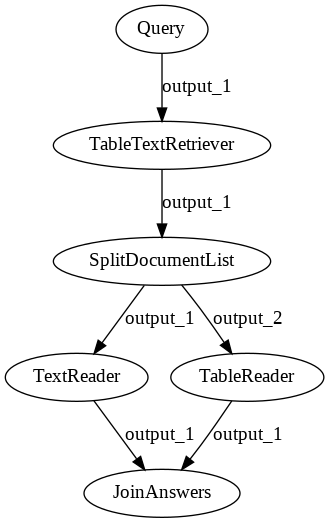

In [55]:
# Let's have a look on the structure of the combined Table an Text QA pipeline.
from IPython import display

text_table_qa_pipeline.draw()
display.Image("pipeline.png")

In [ ]:
# Example query whose answer resides in a text passage
predictions = text_table_qa_pipeline.run(query="Who is Aleksandar Trifunovic?")

In [57]:
# We can see both text passages and tables as contexts of the predicted answers.
print_answers(predictions, details="minimum")


Query: Who is Aleksandar Trifunovic?
Answers:
[   {   'answer': 'a Serbian professional basketball coach and former player',
        'context': 'Aleksandar Trifunović ( ; born 30 May 1967 ) is a Serbian '
                   'professional basketball coach and former player .'},
    {   'answer': 'Johnny Höglin',
        'context':    Rank              Athlete        Country    Time
0     1         Kees Verkerk    Netherlands  2:03.4
1     2         Ivar Eriksen         Norway  2:05.0
2     3           Ard Schenk    Netherlands  2:05.0
3     4      Magne Thomassen         Norway  2:05.1
4     5        Johnny Höglin         Sweden  2:05.2
5     5         Bjørn Tveter         Norway  2:05.2
6     7  Svein-Erik Stiansen         Norway  2:05.5
7     8    Eduard Matusevich   Soviet Union  2:06.1
8     9         Peter Nottet    Netherlands  2:06.3
9    10        Örjan Sandler         Sweden  2:07.0
10   11  Aleksandr Kerchenko   Soviet Union  2:07.1
11   12          Ants Antson   Soviet Union

In [ ]:
# Example query whose answer resides in a table
predictions = text_table_qa_pipeline.run(query="What is Cuba's national tree?")

In [67]:
# We can see both text passages and tables as contexts of the predicted answers.
print_answers(predictions, details="minimum")


Query: What is Cuba's national tree?
Answers:
[   {   'answer': 'Cuban royal palm',
        'context':                 Country  ...                               Scientific name
0           Afghanistan  ...                                              
1               Albania  ...                                 Olea europaea
2   Antigua and Barbuda  ...                                Bucida buceras
3             Argentina  ...  Erythrina crista-galli , Schinopsis balansae
4             Australia  ...                              Acacia pycnantha
5               Bahamas  ...                              Guaiacum sanctum
6            Bangladesh  ...                              Mangifera indica
7                Belize  ...                         Swietenia macrophylla
8                Bhutan  ...                         Cupressus cashmeriana
9                Brazil  ...                          Caesalpinia echinata
10             Cambodia  ...                          Borassus flabelli

## About us

This [Haystack](https://github.com/deepset-ai/haystack/) notebook was made with love by [deepset](https://deepset.ai/) in Berlin, Germany

We bring NLP to the industry via open source!  
Our focus: Industry specific language models & large scale QA systems.  
  
Some of our other work: 
- [German BERT](https://deepset.ai/german-bert)
- [GermanQuAD and GermanDPR](https://deepset.ai/germanquad)
- [FARM](https://github.com/deepset-ai/FARM)

Get in touch:
[Twitter](https://twitter.com/deepset_ai) | [LinkedIn](https://www.linkedin.com/company/deepset-ai/) | [Slack](https://haystack.deepset.ai/community/join) | [GitHub Discussions](https://github.com/deepset-ai/haystack/discussions) | [Website](https://deepset.ai)

By the way: [we're hiring!](https://www.deepset.ai/jobs)
